## MTurk I/O for Image Dataset

The query of interest is: **The outlined boxes depict a person drinking water** 

Want to generate the input .csv file for MTurk and parse the output csv file for results. Using MTurkHelper from babble with adjustments for candidate type.

In [1]:
import numpy as np
%matplotlib inline

import os
import sys
import pandas as pd


%load_ext autoreload
%autoreload 2

## MTurk Helper for Input CSV

In [2]:
sys.path.append('../data/')
from tutorials.babble import MTurkHelper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We want to make "fake" candidates for the visual tesk since it doesn't fit into the actual sense of the word "candidate". They will just be a list of image names that are saved (how convenient!)

In [3]:
filelist= [file for file in os.listdir('/dfs/scratch0/paroma/visual_genome/') if ((file.startswith('drink-val_')) and (file.endswith('.png')))]
print (len(filelist) % 4 == 0)
print len(filelist)/4

OSError: [Errno 2] No such file or directory: '/dfs/scratch0/paroma/visual_genome/'

In [ ]:
helper = MTurkHelper(candidates=filelist, labels=[], num_hits=1+len(filelist)/4)

In [ ]:
input_csv_path = './data/Labels_for_Drink_v0.1.csv'
helper.preprocess_visual(input_csv_path)

## MTurk Helper for Output Labels CSV

In [13]:
output_csv_path = (os.environ['SNORKELHOME'] + '/tutorials/babble/drink/data/Reach_Val_Labels_out.csv')

Reading val CSV!
Num HITs unique: 184
Num HITs total: 368


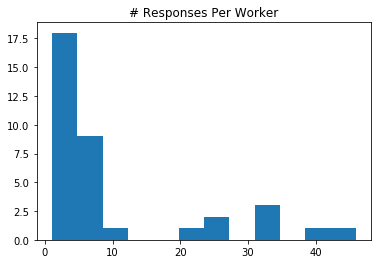

Median # seconds/HIT: 321 (80.0 s/explanation)


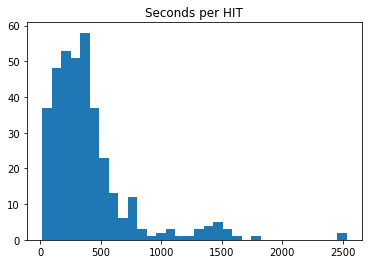

Unanimous: 474
Majority: 318
Bad: 100


In [14]:
helper = MTurkHelper(candidates=[], labels=[], num_hits=None, domain='vg', workers_per_hit=2)
labels_by_candidate = helper.postprocess_visual(output_csv_path, is_gold=True, set_name='val', candidates=[], verbose=True)

In [15]:
print "Number of Valid Dev Set Candidates: ", len(labels_by_candidate)
#np.save('/dfs/scratch0/paroma/coco/annotations/drink_val_labels_by_candidate.npy', np.array(labels_by_candidate))

Number of Valid Dev Set Candidates:  634


In [7]:
np.shape(np.where(np.array(labels_by_candidate.values()) == False))[1]

466

## MTurk Helper for Explanation Generation

## Generating Train Candidates for Labels

In [ ]:
all_train_cand = [file for file in os.listdir('/dfs/scratch0/paroma/visual_genome/') 
                  if ((file.startswith('drink-train_')) and (file.endswith('.png')))]
print 'Num HITs: ', int(round(len(all_train_cand)/4.0))

In [ ]:
helper = MTurkHelper(candidates=all_train_cand, labels=[], num_hits=int(round(len(all_train_cand)/4.0)))

In [ ]:
# input_csv_path = './data/Drink_Train_Labels_in.csv'
# helper.preprocess_visual(input_csv_path)

In [ ]:
output_csv_path = (os.environ['SNORKELHOME'] + '/tutorials/babble/drink/data/Reach_Train_Labels_out.csv')

In [ ]:
helper = MTurkHelper(candidates=[], labels=[], num_hits=int(round(len(all_train_cand)/4.0)), domain='vg', workers_per_hit=2)
labels_by_candidate = helper.postprocess_visual(output_csv_path, is_gold=True, set_name='train', verbose=True)

In [ ]:
np.shape(np.where(np.array(labels_by_candidate.values()) == True))[1]

In [ ]:
print "Number of Valid Train Set Candidates: ", len(labels_by_candidate)
#np.save('/dfs/scratch0/paroma/coco/annotations/drink_train_labels_by_candidate.npy', np.array(labels_by_candidate))

## MTurk Helper for Explanations CSV

In [ ]:
filelist= [file for file in os.listdir('/dfs/scratch0/paroma/visual_genome/') if ((file.startswith('drink-train_')) and (file.endswith('.png')))]
filelist.sort()

#Need to do some proceessing to ensure positive examples are ~40% of the candidates
#Also ensure all candidates in an image get a crowd explanation+label (for FS comparison)
np.random.seed(1234)
valid_keys = [key for key in labels_by_candidate.keys() if str(key).startswith('train')]
true_keys = [key for key in labels_by_candidate.keys() if labels_by_candidate[key] == True]
random_true_keys = np.random.choice(true_keys, replace=False, size=25)

filelist_filtered = []
for true_key in random_true_keys:
    filelist_filtered.append([true_key])
    filelist_filtered.append([key for key in labels_by_candidate.keys() if str(key).startswith(true_key[0:9])])
filelist_filtered = set(sum(filelist_filtered, []))
list(filelist_filtered).sort()

selected_labels = [labels_by_candidate[key] for key in filelist_filtered]
print 'Total Explanation Candidates: ', len(filelist_filtered)
print 'Positive Examples in Explanation Labels:', np.shape(np.where(np.array(selected_labels) == True))[1]/float(len(filelist_filtered))

In [ ]:
helper = MTurkHelper(candidates=filelist, labels=[], num_hits=len(filelist_filtered)/4)

In [ ]:
input_csv_path = './data/Reach_Explanation_in.csv'
helper.preprocess_visual(input_csv_path)

**Output CSV Analysis**

In [ ]:
output_csv_path = (os.environ['SNORKELHOME'] + '/tutorials/babble/drink/data/Drink_VisualGenome_out.csv')

In [ ]:
helper = MTurkHelper(candidates=[], labels=[], num_hits=40, domain='vg', workers_per_hit=3)
explanations = helper.postprocess_visual(output_csv_path, set_name='train', candidates=[], verbose=True)

## Debugging for BabblePipeline

In [ ]:
from snorkel.contrib.babble import Babbler
user_lists = {}
babbler = Babbler(mode='image', explanations=explanations)

In [ ]:
lfs = babbler.generate_lfs()
babbler.get_explanations()

In [ ]:
babbler.filter_duplicate_semantics()